In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from geopy.distance import geodesic

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [5]:
pd.set_option('display.max_colwidth', None)

In [29]:
# Force garbage collection
import gc
gc.collect()

3126

In [6]:
location_dat = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter/wind_speed_filtered.parquet')[['lon', 'lat']]
# deduplicate
location_dat = location_dat.drop_duplicates()
# reindex the data
location_dat = location_dat.reset_index(drop=True)

In [8]:
location_dat.head()

,lon,lat
0,-124.391667,40.441667
1,-124.391667,40.400000
2,-124.350000,40.566667
3,-124.350000,40.525000
4,-124.350000,40.483333


In [9]:
# read fire data
fire_data_location = pd.read_parquet('../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup.parquet')[['LONGITUDE', 'LATITUDE']]
# deduplicate
fire_data_location = fire_data_location.drop_duplicates()
# reindex the data
fire_data_location = fire_data_location.reset_index(drop=True)

In [12]:
# rename the columns to lon and lat
fire_data_location = fire_data_location.rename(columns={'LONGITUDE': 'lon', 'LATITUDE': 'lat'})

In [13]:
fire_data_location.head()

,lon,lat
0,-123.943617,40.476117
1,-120.850714,38.641597
2,-121.607969,39.806769
3,-123.163889,39.678056
4,-120.710000,38.293056


In [14]:
fire_data_location.shape

(148035, 2)

In [15]:
from scipy.spatial import cKDTree

# Create a KDTree for the vegetation_dat coordinates
tree = cKDTree(fire_data_location[['lat', 'lon']].values)

# Query the nearest neighbors for each point in location_dat
approx_distances, indices = tree.query(location_dat[['lat', 'lon']].values, k=1)

In [16]:
# Calculate the exact geodesic distances
exact_distances = []
for i, idx in enumerate(indices):
    coords_1 = (location_dat.iloc[i]['lat'], location_dat.iloc[i]['lon'])
    coords_2 = (fire_data_location.iloc[idx]['lat'], fire_data_location.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

In [17]:
exact_distances.min(), exact_distances.max()

(2.4990948926365377e-06, 86.73139771421184)

In [18]:
# Filter out distances greater than 10 km
mask = exact_distances < 12
# Assign the nearest type and distance to lon_lat_combinations
# location_dat['type'] = np.where(mask, fire_data_location.iloc[indices]['type'].values, np.nan)
location_dat['distance'] = np.where(mask, exact_distances, np.nan)

In [19]:
# check missing % of distance
location_dat['distance'].isnull().mean()

0.009772354968084505

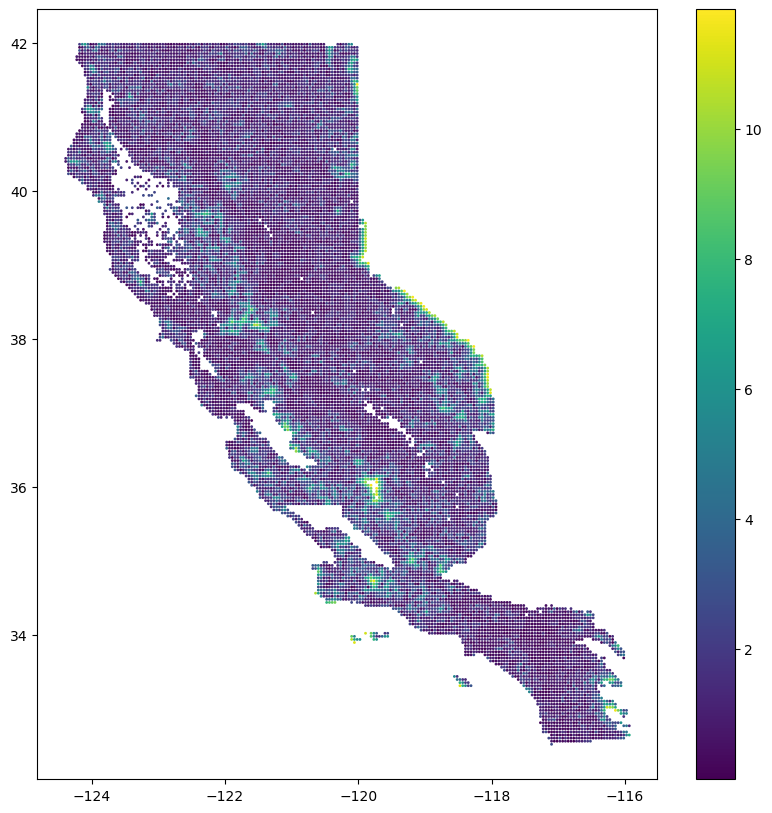

In [20]:
# 12km
plt.figure(figsize=(10, 10))
plt.scatter(location_dat['lon'], location_dat['lat'], c=location_dat['distance'], cmap='viridis', s = 1)
plt.colorbar()
plt.show()

1% of grids will be removed from final analysis

In [21]:
# remove missing distance
location_dat = location_dat.dropna(subset=['distance'])
# drop column distance
location_dat = location_dat.drop(columns=['distance'])

In [22]:
location_dat.head()

,lon,lat
0,-124.391667,40.441667
1,-124.391667,40.400000
2,-124.350000,40.566667
3,-124.350000,40.525000
4,-124.350000,40.483333


In [23]:
# print if there is any duplicated
location_dat.duplicated().sum()

0

In [24]:
files = os.listdir('../Clean_Data/Weather_Data_w_Veg_Filter/')
files

['dead_fuel_moisture_1000hr_filtered.parquet',
 'dead_fuel_moisture_100hr_filtered.parquet',
 'expanded_Palmer_Drought_Severity_Index_filtered.parquet',
 'max_air_temperature_filtered.parquet',
 'max_relative_humidity_filtered.parquet',
 'max_wind_speed_filtered.parquet',
 'min_air_temperature_filtered.parquet',
 'min_relative_humidity_filtered.parquet',
 'precipitation_amount_filtered.parquet',
 'specific_humidity_filtered.parquet',
 'surface_downwelling_shortwave_flux_filtered.parquet',
 'wind_from_direction_filtered.parquet',
 'wind_speed_filtered.parquet']

In [31]:
# read each saved parquet file with a progress bar
for file in tqdm(files, desc="Processing files"):
    # print the file name
    print(file)
    panda_df = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter/{file}')
    # merge the dataframes
    merged_df = pd.merge(panda_df, location_dat, on=['lon', 'lat'], how='inner')
    # save the merged dataframe
    merged_df.to_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/{file}')
    # print the shape of the merged dataframe before and after
    print(panda_df.shape, merged_df.shape)

Processing files:   0%|          | 0/13 [00:00<?, ?it/s]

dead_fuel_moisture_1000hr_filtered.parquet


Processing files:   8%|▊         | 1/13 [00:33<06:42, 33.53s/it]

(148705200, 4) (147252000, 4)
dead_fuel_moisture_100hr_filtered.parquet


Processing files:  15%|█▌        | 2/13 [01:05<06:00, 32.79s/it]

(148705200, 4) (147252000, 4)
expanded_Palmer_Drought_Severity_Index_filtered.parquet


Processing files:  23%|██▎       | 3/13 [01:42<05:45, 34.59s/it]

(148705200, 5) (147252000, 5)
max_air_temperature_filtered.parquet


Processing files:  31%|███       | 4/13 [02:12<04:55, 32.81s/it]

(148705200, 4) (147252000, 4)
max_relative_humidity_filtered.parquet


Processing files:  38%|███▊      | 5/13 [02:44<04:18, 32.31s/it]

(148705200, 4) (147252000, 4)
max_wind_speed_filtered.parquet


Processing files:  46%|████▌     | 6/13 [03:17<03:49, 32.72s/it]

(148705200, 4) (147252000, 4)
min_air_temperature_filtered.parquet


Processing files:  54%|█████▍    | 7/13 [03:48<03:13, 32.19s/it]

(148705200, 4) (147252000, 4)
min_relative_humidity_filtered.parquet


Processing files:  62%|██████▏   | 8/13 [04:18<02:37, 31.57s/it]

(148705200, 4) (147252000, 4)
precipitation_amount_filtered.parquet


Processing files:  69%|██████▉   | 9/13 [04:48<02:03, 30.92s/it]

(148705200, 4) (147252000, 4)
specific_humidity_filtered.parquet


Processing files:  77%|███████▋  | 10/13 [05:17<01:31, 30.48s/it]

(148705200, 4) (147252000, 4)
surface_downwelling_shortwave_flux_filtered.parquet


Processing files:  85%|████████▍ | 11/13 [05:49<01:01, 30.77s/it]

(148705200, 4) (147252000, 4)
wind_from_direction_filtered.parquet


Processing files:  92%|█████████▏| 12/13 [06:19<00:30, 30.56s/it]

(148705200, 4) (147252000, 4)
wind_speed_filtered.parquet


Processing files: 100%|██████████| 13/13 [06:50<00:00, 31.58s/it]

(148705200, 4) (147252000, 4)


In [32]:
merged_df.head()

,lon,lat,day,wind_speed
0,-124.391667,40.441667,2001-01-01,4.8
1,-124.391667,40.441667,2001-01-02,2.1
2,-124.391667,40.441667,2001-01-03,3.3
3,-124.391667,40.441667,2001-01-04,2.0
4,-124.391667,40.441667,2001-01-05,4.2


In [33]:
147252000/148705200

0.9902276450319155

In [39]:
# Force garbage collection
import gc
gc.collect()

1230

In [40]:
# read all the saved parquet files, merge them and save them
files = os.listdir('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/')
# read the first file
all_features = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/{files[0]}')


# Read the rest of the files with a progress bar
for file in tqdm(files[1:], desc="Merging files"):
    # Read the file
    panda_df = pd.read_parquet(f'../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM/{file}')

    # Rename columns based on conditions
    if 'air_temperature' in panda_df.columns:
        if 'max' in file:
            panda_df.rename(columns={'air_temperature': 'max_air_temperature'}, inplace=True)
            print(f"Renamed 'air_temperature' to 'max_air_temperature' in file {file}")
        elif 'min' in file:
            panda_df.rename(columns={'air_temperature': 'min_air_temperature'}, inplace=True)
            print(f"Renamed 'air_temperature' to 'min_air_temperature' in file {file}")
    
    if 'relative_humidity' in panda_df.columns:
        if 'max' in file:
            panda_df.rename(columns={'relative_humidity': 'max_relative_humidity'}, inplace=True)
            print(f"Renamed 'relative_humidity' to 'max_relative_humidity' in file {file}")
        elif 'min' in file:
            panda_df.rename(columns={'relative_humidity': 'min_relative_humidity'}, inplace=True)
            print(f"Renamed 'relative_humidity' to 'min_relative_humidity' in file {file}")
            
    if all_features.shape[0] == panda_df.shape[0]:
        all_features = pd.merge(all_features, panda_df, on=['lon', 'lat', 'day'], how='inner')
    else:
        print(f"Shape mismatch for file {file}")

Merging files:  17%|█▋        | 2/12 [03:10<15:41, 94.14s/it] 

Renamed 'air_temperature' to 'max_air_temperature' in file max_air_temperature_filtered.parquet


Merging files:  25%|██▌       | 3/12 [04:44<14:06, 94.07s/it]

Renamed 'relative_humidity' to 'max_relative_humidity' in file max_relative_humidity_filtered.parquet


Merging files:  42%|████▏     | 5/12 [07:51<10:54, 93.47s/it]

Renamed 'air_temperature' to 'min_air_temperature' in file min_air_temperature_filtered.parquet


Merging files:  50%|█████     | 6/12 [09:23<09:18, 93.05s/it]

Renamed 'relative_humidity' to 'min_relative_humidity' in file min_relative_humidity_filtered.parquet


Merging files: 100%|██████████| 12/12 [18:49<00:00, 94.16s/it]


In [41]:
all_features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi                                                float32
category                                            float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

In [42]:
# save the merged dataframe
all_features.to_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged.parquet')

In [47]:
# Force garbage collection
import gc
gc.collect()

1444

In [48]:
# read the merged dataframe
all_features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged.parquet')

In [49]:
all_features.rename(columns={'category': 'pdsi_class'}, inplace=True)

In [50]:
check_rows = all_features[all_features['max_air_temperature'] < all_features['min_air_temperature']]
check_rows.shape

(3806, 17)

In [53]:
# check the max difference between max and min air temperature in check_rows
check_rows['air_temperature_diff'] = check_rows['min_air_temperature'] - check_rows['max_air_temperature']
# describe the air_temperature_diff
check_rows['air_temperature_diff'].describe()

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_63448\2203102295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_rows['air_temperature_diff'] = check_rows['min_air_temperature'] - check_rows['max_air_temperature']


count    3806.000000
mean        0.461429
std         0.488990
min         0.100000
25%         0.200000
50%         0.300000
75%         0.500000
max         4.500000
Name: air_temperature_diff, dtype: float64

In [54]:
# in all_features, replace the max_air_temperature with min_air_temperature where max_air_temperature < min_air_temperature
all_features['max_air_temperature'] = np.where(all_features['max_air_temperature'] < all_features['min_air_temperature'], all_features['min_air_temperature'], all_features['max_air_temperature'])

In [55]:
all_features[all_features['max_air_temperature'] < all_features['min_air_temperature']].shape

(0, 17)

In [56]:
all_features['precipitation_amount'].fillna(0, inplace=True)

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_63448\3267692981.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_features['precipitation_amount'].fillna(0, inplace=True)


In [69]:
# check column wind_from_direction
all_features['wind_from_direction'].describe()

count    1.457040e+08
mean     2.204980e+02
std      1.228511e+02
min      1.000000e+00
25%      1.630000e+02
50%      2.350000e+02
75%      3.020000e+02
max      3.600000e+02
Name: wind_from_direction, dtype: float64

In [70]:
# wind direction is in degrees, so it should be between 0 and 360. add a categorical column for wind direction to divide it into 8 categories
all_features['wind_direction_category'] = pd.cut(all_features['wind_from_direction'], bins=8, labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

In [72]:
all_features.groupby('wind_direction_category')['wind_from_direction'].describe()

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_63448\3143643414.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_features.groupby('wind_direction_category')['wind_from_direction'].describe()


,count,mean,std,min,25%,50%,75%,max
wind_direction_category,,,,,,,,
N,10661357.0,21.979839,13.101885,1.0,10.0,21.0,33.0,45.0
NE,8231787.0,66.715881,12.970941,46.0,55.0,66.0,78.0,90.0
E,8622323.0,114.999535,13.371246,91.0,104.0,116.0,127.0,135.0
SE,16571214.0,160.056854,13.971778,136.0,150.0,161.0,171.0,180.0
S,22883047.0,204.405884,20.769289,181.0,193.0,205.0,216.0,225.0
SW,25279853.0,247.323608,29.596216,226.0,236.0,247.0,258.0,270.0
W,28114948.0,295.538696,15.950545,271.0,284.0,297.0,307.0,315.0
NW,25339478.0,333.913452,13.353882,316.0,323.0,332.0,344.0,360.0


In [75]:
all_features.dtypes

lon                                                 float64
lat                                                 float64
day                                          datetime64[ns]
dead_fuel_moisture_1000hr                           float32
dead_fuel_moisture_100hr                            float32
pdsi                                                float32
pdsi_class                                          float32
max_air_temperature                                 float64
max_relative_humidity                               float32
max_wind_speed                                      float32
min_air_temperature                                 float64
min_relative_humidity                               float32
precipitation_amount                                float32
specific_humidity                                   float32
surface_downwelling_shortwave_flux_in_air           float32
wind_from_direction                                 float32
wind_speed                              

In [77]:
all_features.to_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned.parquet')

## Keep Data Before 2020

In [81]:
# Force garbage collection
import gc
gc.collect()

604

In [82]:
# read the cleaned merged dataframe
all_features = pd.read_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned.parquet')

In [83]:
all_features.shape, all_features.dtypes

((147252000, 18),
 lon                                                 float64
 lat                                                 float64
 day                                          datetime64[ns]
 dead_fuel_moisture_1000hr                           float32
 dead_fuel_moisture_100hr                            float32
 pdsi                                                float32
 pdsi_class                                          float32
 max_air_temperature                                 float64
 max_relative_humidity                               float32
 max_wind_speed                                      float32
 min_air_temperature                                 float64
 min_relative_humidity                               float32
 precipitation_amount                                float32
 specific_humidity                                   float32
 surface_downwelling_shortwave_flux_in_air           float32
 wind_from_direction                                 float32
 wind_

In [84]:
all_features_2020 = all_features[all_features['day'] <= '2020-12-31']

In [85]:
all_features_2020.shape

(128056650, 18)

In [86]:
# check max and min of day
all_features_2020['day'].min(), all_features_2020['day'].max()

(Timestamp('2001-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [87]:
all_features_2020.to_parquet('../Clean_Data/Weather_Data_w_Veg_Filter_FOD_FPA_Fire_12KM_Merged_Cleaned_2001_2020.parquet')